### Convolutional Neural Networks

Neural Networks are based on a collection of connected units or nodes called "neurons", which try to simulate, in a very simplistic manner, the way neurons interact in an animal's brain.  
Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it.

CNNs are a kind of neural network that attempts to look at images the way the humans do, extract information from them and pass it to the artificial neurons tasked with handling this information in the fully connected layers.

![image.png](img/cnn.jpeg)


Convolution filters look at the image progressively, using a sliding window. This allows it to focus on one piece of the image at a time, learning to extract the most important information from each portion of the image. 

![SegmentLocal](img/sliding_window.gif "segment")


This is similar to how the human brain looks at images. The human is mostly very low resolution, except for a tiny patch called the **fovea**. Though we feel as if we can see an entire scene in high resolution, this is an ilussion created by our brain who stitches together several glimpses of small areas captured by the **fovea**.


For more information on how CNNs work you can visit:
* [Convolutional Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)
* [Visualizing parts of Convolutional Neural Networks](https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59)


### Dataset

MNIST is a very simple dataset consisting of **binary images** (black and white images) of handwritten digits with a size of 28x28 pixels. The task is to create a model that tell which digit is written on each image.



#### Here are a few examples of each class

![image.png](img/mnist.png)

#### Today I will show you how neural networks can accomplish this task rather easily. 
#### We will implement a neural network using the python library, [PyTorch](https://pytorch.org/)

In [1]:
# Import the necessary libraries
import torch
import time as t
from torchvision import transforms
import torchvision.datasets as dset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Before feeding the images to our model it's always a good idea to preprocess them a bit. To do this, PyTorch provides the **data.transforms** [module](https://pytorch.org/docs/stable/torchvision/transforms.html). 

We will apply 1 tranformation to every image: 

1. Convert the image to a tensor: Image are usually represented as a 3D array with the a shape of **H x W x C**, containing RGB values ranging from 0 to 255. In this case since they are binary images they have only 2 possible values: 0 **or** 255. So what this operation will do is change the shape of each image to **C x H x W** and make the range of values between 0 and 1, or in our particular case, 0 **or** 1. This will also convert the images to tensors*. 

*For computer science purposes you can think of a tensor as an array that can be stored in GPU.

In [2]:
# Create transforms
data_transforms = transforms.ToTensor()

In [3]:
#Pytorch allows us to download some datasets directly from the web and apply every transform while at it.

# Download train and validation sets
train = dset.MNIST('data', download=True, train=True, transform=data_transforms)
val = dset.MNIST('data', download=True, train=False, transform=data_transforms)

In [4]:
# Optimizaiton config
batch_size = 256 # Number of samples used to estimate the gradient (bigger=more stable training)
epochs = 5 # Number of iterations over the whole dataset.

Once we have our data on disk we can use PyTorch [dataloaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to load them into memory using batches and shuffling them if needed. We can also use several workers to load the data in parallel preventing it from becoming a bottleneck

In [5]:
# Load training and validation datasets

# Shuffle the traning set to maximize the probability of every class being present in every batch
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
# We do not need to shuffle the validation set
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
class NeuralNet(torch.nn.Module):
    def __init__(self, labels=10, kernel_size=5):
        super().__init__() # Necessary for PyTorch to detect this class as trainable
        
        # Here define network architecture
        self.conv1 = nn.Conv2d(1, 20, kernel_size=kernel_size)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.nolinear1 = nn.ReLU()

        self.conv2 = nn.Conv2d(20, 50, kernel_size=kernel_size)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.nolinear2 = nn.ReLU()

        self.fc1 = nn.Linear(4*4*50, 100)
        self.nolinear3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        
        # Here define architecture behavior
        x = self.nolinear1(self.pool1((self.conv1(x))))
        x = self.nolinear2(self.pool2((self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.nolinear3(self.fc1(x))
       
        return self.fc2(x)  

In [7]:
# Instantiate network
model = NeuralNet()

### Loss function
The loss function we will try to minimize is the cross entropy. Give by the equation: 

$$Cross Entropy=-\sum_{x}p(x)logq(x)$$


Where $p(x)$ is the actual distribution of the data and $q(x)$ is the distribution predicted by our model. By minimizing this function we are maximizing the similarities between the actual distribution and the one predicted by our model, thus making our model more accurate.


Notice that the cross entropy loss takes a probability distribution as input so we must apply a softmax operation to the output of our model, before computing the loss:
![image.png](img/cross_entropy_loss.jpg)

You can find a lot more about Cross Entropy Loss here:

* [Softmax-crossentropy](https://deepnotes.io/softmax-crossentropy)
* [A gentle introduction to cross entropy loss function](https://sefiks.com/2017/12/17/a-gentle-introduction-to-cross-entropy-loss-function/)




In [8]:
# Instantiate loss function
criterion = torch.nn.CrossEntropyLoss() 

### Choosing an optimizer
The optimizer is the one that will perform the update to the parameters in our neural network after the gradients are computed using backpropagation. For this experiment we will use the SGD (stochastic gradient descent) optimizer. 

The update performed by the SGD optimizer is as follows:


$$v_t =\gamma{v_{t-1}} - \alpha{\nabla\theta{J(\theta)}} $$ 
$$ \theta = \theta - v_t $$

Where: 
* $V_{t}$ the update vector at iteration $t$
* $\theta$ are the parameters of our model .
* $\nabla{J(\theta)}$ is the gradient of the loss function (which is parametrized by our model parameters). 
* $\gamma$ is the momemtum value, which represents what portion of the previous update we add to this one. Usually takes values around 0.9.
* $\alpha$ is the learning rate, which represents what portion of the gradient we navigate. I'ts value usually is between 0 and 1, and can vary a lot inside that range. Notice that the higher your batch size is, the better the computated gradients are and thus you can "trust" them more and increase the learning rate.


There are many optimizers that perform parameters updates which are more sophisticated than this one, but usually **SGD** or **Adam** are safe choices.



For a better understanding of each optimizer I **highly** recommend you read [Sebastians Ruders's blogpost](http://ruder.io/optimizing-gradient-descent/) explaining how each optimizer works.

In [9]:
# Create optimizer for the network parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

In [10]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def train():
    
    model.train() # set model to training mode
    
    running_loss = 0
    running_corrects = 0
    total = 0

    for data, labels in train_loader:
        
        optimizer.zero_grad()  # make the gradients 0
        
        x = data.to(device)
        y = labels.to(device)
        
        output = model(x)  # forward pass
        loss = criterion(output, y)  # calculate the loss value
        preds = output.max(1)[1] # get the predictions for each sample


        loss.backward() # compute the gradients
        optimizer.step() # uptade network parameters

        # statistics
        running_loss += loss.item() * x.size(0)
        # .item() converts type from torch to python float or int
        running_corrects += torch.sum(preds == y).item()
        total += float(y.size(0))

    epoch_loss = running_loss / total  # mean epoch loss
    epoch_acc = running_corrects / total  # mean epoch accuracy

    return epoch_loss, epoch_acc


In [12]:
def val():

    model.eval()  # set model to validation mode

    running_loss = 0
    running_corrects = 0
    total = 0
    
    # We are not backpropagating through the validation set, so we can save time  and memory 
    # by not computing the gradients
    with torch.no_grad():
        
        for data, labels in val_loader:
            
            x = data.to(device)
            y = labels.to(device)
        
            output = model(x)  # forward pass 
            
            # Calculate the loss value (we do not to apply softmax to our output because Pytorch's 
            # implementation of the cross entropy loss does it for us)
            loss = criterion(output, y) 
            preds = output.max(1)[1] # get the predictions for each sample
            
            # Statistics
            running_loss += loss.item() * x.size(0)
            # .item() converts type from torch to python float or int
            running_corrects += torch.sum(preds==y).item()
            total += float(y.size(0))
    
    epoch_loss = running_loss / total # mean epoch loss
    epoch_acc = running_corrects / total # mean epoch accuracy
    
    return epoch_loss, epoch_acc

In [13]:
losses = []
accuracies = []

for epoch in range(epochs):

    start = t.time()
    
    train_loss, train_acc = train()
    losses.append(train_loss)
    accuracies.append(train_acc)
    
    print('-' * 74)
    print('| End of epoch: {:3d} | Time: {:.2f}s | Train loss: {:.3f} | Train acc: {:.3f}|'
          .format(epoch + 1, t.time() - start, train_loss, train_acc))

    start = t.time()
    
    val_loss, val_acc = val()
    losses.append(val_loss)
    accuracies.append(val_acc)
    
    print('-' * 74)
    print('| End of epoch: {:3d} | Time: {:.2f}s | Val loss: {:.3f} | Val acc: {:.3f}|'
          .format(epoch + 1, t.time() - start, val_loss, val_acc))

--------------------------------------------------------------------------
| End of epoch:   1 | Time: 26.01s | Train loss: 0.765 | Train acc: 0.783|
--------------------------------------------------------------------------
| End of epoch:   1 | Time: 2.18s | Val loss: 0.183 | Val acc: 0.945|
--------------------------------------------------------------------------
| End of epoch:   2 | Time: 23.38s | Train loss: 0.145 | Train acc: 0.956|
--------------------------------------------------------------------------
| End of epoch:   2 | Time: 1.88s | Val loss: 0.093 | Val acc: 0.971|
--------------------------------------------------------------------------
| End of epoch:   3 | Time: 23.14s | Train loss: 0.095 | Train acc: 0.971|
--------------------------------------------------------------------------
| End of epoch:   3 | Time: 1.81s | Val loss: 0.072 | Val acc: 0.977|
--------------------------------------------------------------------------
| End of epoch:   4 | Time: 25.29s | Tra

In [14]:
losses = np.array([losses]).reshape(epochs, -1)
accuracies = np.array([accuracies]).reshape(epochs, -1)

### Visualizing Loss and Accuracy

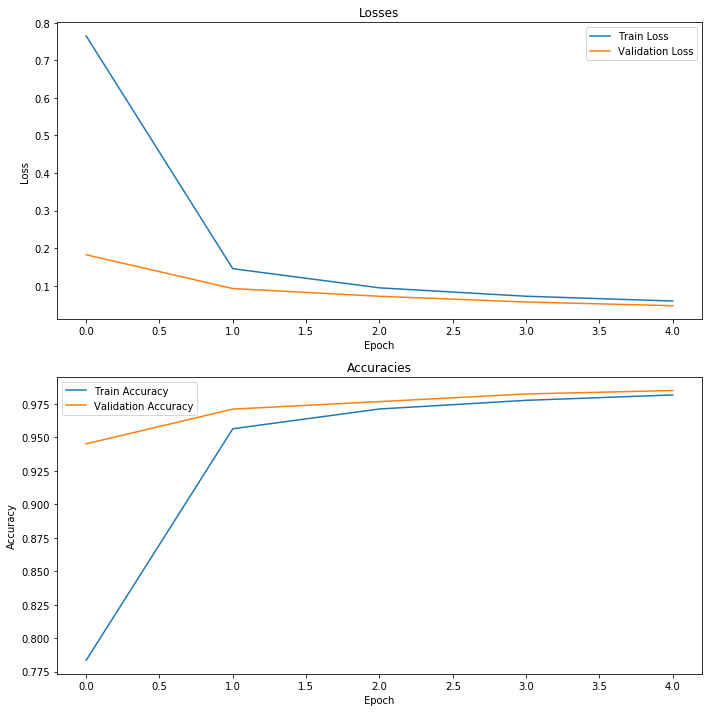

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].set_title("Losses")
ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train Loss', 'Validation Loss'])

ax[1].set_title("Accuracies")
ax[1].plot(accuracies)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train Accuracy', 'Validation Accuracy'])


ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()

As you can see both of our losses **converge** at almost the same **low** point, thus achieving a **high accuracy** score.

In [16]:
def imshow(img, ax):
    
    out = img.data.numpy()
    out = out - out.min()
    out = out / out.max()
    out = out * 255
    out = out.astype('uint8')
    ax.axes.get_xaxis().set_visible(False)        
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(out, cmap='gray')

In [17]:
def show_conv_map(conv_map, title, shape):
    
    h = shape[0]
    w = shape[1]
    fig, ax = plt.subplots(h, w, figsize=(10, 10))

    # Show every channel's feature map
    fig.suptitle(title, fontsize=20)
    for i in range(conv_map.shape[0]):
        imshow(conv_map[i], ax[i//w, i%w])
    
    fig.tight_layout()
    

### Visualizing Feature Maps

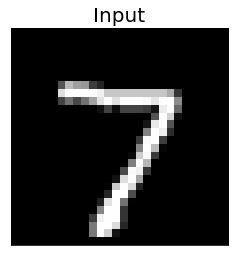

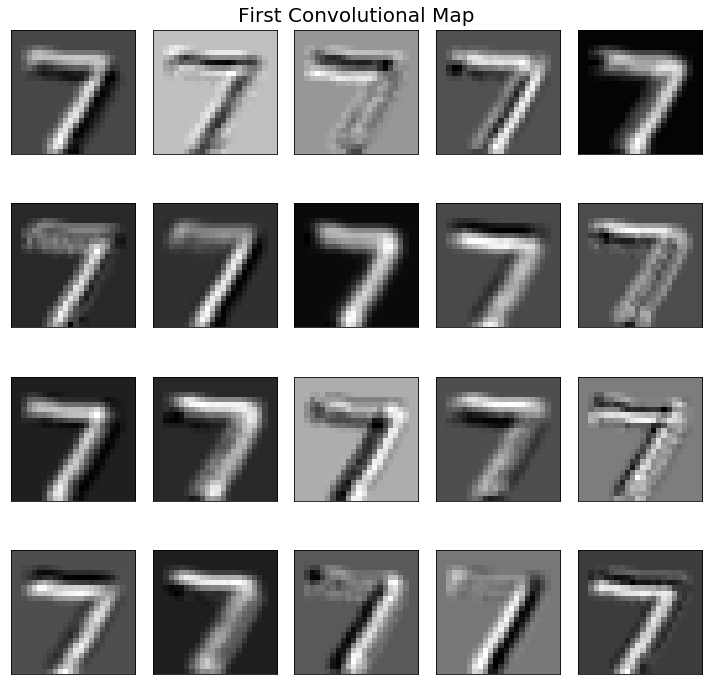

In [18]:
# Extract the feature map output of the convolutional layers
conv1_map = model.conv1(val_loader.dataset[0][0].unsqueeze_(0)).squeeze_()

plt.figure()
plt.title("Input", fontsize=20)
img = val_loader.dataset[0][0].squeeze_()
imshow(img, plt.gca())

show_conv_map(conv1_map, title='First Convolutional Map', shape=(4, 5))

**The white specs in the image are the ones that the CNN is "looking" at**.

As you can see, some of the channels in the first convolutionn clearly are specialized in detecting edges and curves in the numbers 



### Conclusion

We learned how to program a very simple CNN and saw how powerful they can be in computer vision related tasks. We gained a very brief insight into how Convolutional Neural Networks work and visualized what they "see" in an image, learning how is it that they learn to pay attention. 
